Kovaznay Flow: Governing Equations
Navier-Stokes Equations
The complete set of governing equations consists of:
Continuity Equation (Conservation of Mass)
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$
Momentum Equation (x-direction)
$$u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \frac{1}{\text{Re}} \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$
Momentum Equation (y-direction)
$$u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \frac{1}{\text{Re}} \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)$$
Where:

$u, v$ are velocity components in $x$ and $y$ directions
$p$ is pressure
$\text{Re}$ is the Reynolds number

Steady-State Assumptions
For the Kovaznay flow, additional assumptions are made:

Steady-state flow ($\frac{\partial}{\partial t} = 0$)
Incompressible flow
Low Reynolds number regime

Solution Form
The exact solution satisfies these equations with:

Velocity components: $u(x,y), v(x,y)$
Pressure: $p(x,y)$

Where the specific forms are:
$$u(x,y) = 1 - e^{\lambda x}\cos(2\pi y)$$
$$v(x,y) = \frac{\lambda}{2\pi}e^{\lambda x}\sin(2\pi y)$$
$$p(x,y) = -\frac{1}{2}e^{2\lambda x}$$
With $\lambda = -\frac{1}{2} \pm \sqrt{\frac{1}{4} - (2\pi)^2}$
Dimensionless Parameters

Reynolds number: $\text{Re} = \frac{UL}{\nu}$
$U$: Characteristic velocity
$L$: Characteristic length
$\nu$: Kinematic viscosity

## 1. Import Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 2. Exact Solution


In [ ]:
# Domain extremes
x_min, x_max = -0.5, 1.0
y_min, y_max = -0.5, 1.5

# Define the exact solution for Kovasznay flow
def kovasznay_solution(x, y):

    mu = 1.0 / 40.0
    lambda_ = tf.constant( 1 / (2.0 * mu) - np.sqrt( (1.0) / (4.0 * mu ** 2) + 4.0 * (np.pi ** 2) ), dtype=tf.float32)
    u = 1.0 - tf.exp(lambda_ * x) * tf.cos(2 * np.pi * y)
    v = ( lambda_ / (2 * np.pi) ) * tf.exp(lambda_ * x) * tf.sin(2 * np.pi * y)
    p = 0.5 * (1.0 - tf.exp(2 * lambda_ * x))
    return u, v, p


## 3. PINN model

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(100,
                                  activation="tanh",
                                  kernel_initializer='glorot_uniform',
                                  dtype=tf.float32,
                                  bias_initializer='zeros') for _ in range(7)
        ]

        # Output layer without activation
        self.output_layer = tf.keras.layers.Dense(3, activation=None)  # u, v, p

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

## 4. Boundary Data

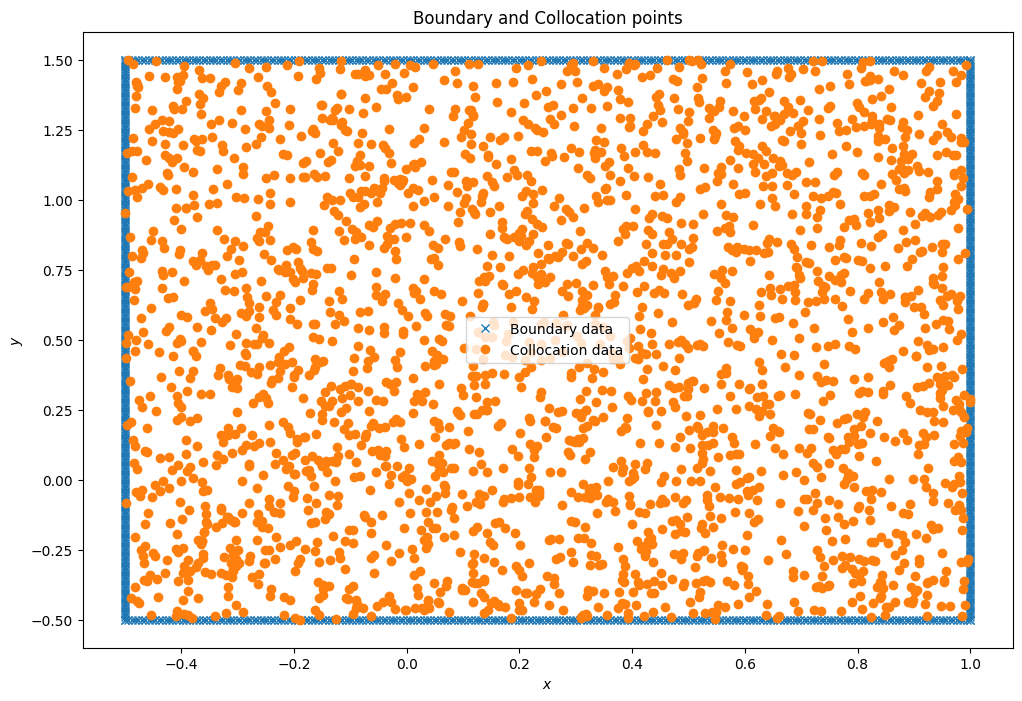

In [ ]:
def generate_training_data(n_collocation, n_boundary):
    """
    Generate training data for collocation points (interior) and boundary points.

    Args:
        n_collocation: Number of collocation (interior) points.
        n_boundary: Number of boundary points (divided across all boundaries).

    Returns:
        x_collocation, y_collocation: Collocation points for residual computation.
        x_boundary, y_boundary: Boundary points for boundary loss computation.
    """
    # Collocation points (interior of the domain)
    x_collocation = np.random.uniform(x_min, x_max, n_collocation)
    y_collocation = np.random.uniform(y_min, y_max, n_collocation)

    # Generate boundary points
    n_each = n_boundary // 4  # Equal distribution of points on each boundary

    # Bottom boundary (y=0)
    x_bottom = np.linspace(x_min, x_max, n_each)
    y_bottom = np.full(x_bottom.shape, y_min)

    # Top boundary (y=1)
    x_top = np.linspace(x_min, x_max, n_each)
    y_top = np.full(x_top.shape, y_max)

    # Left boundary (x=0)
    y_left = np.linspace(y_min, y_max, n_each)
    x_left = np.full(y_left.shape, x_min)

    # Right boundary (x=1)
    y_right = np.linspace(y_min, y_max, n_each)
    x_right = np.ones_like(y_right)

    # Combine boundary points
    x_boundary = np.concatenate([x_bottom, x_top, x_left, x_right])
    y_boundary = np.concatenate([y_bottom, y_top, y_left, y_right])

    return (
        tf.convert_to_tensor(x_collocation, dtype=tf.float32),
        tf.convert_to_tensor(y_collocation, dtype=tf.float32),
        tf.convert_to_tensor(x_boundary, dtype=tf.float32),
        tf.convert_to_tensor(y_boundary, dtype=tf.float32),
    )


def plot(x_boundary, y_boundary, x_collocation, y_collocation):

    plt.figure(figsize=(12, 8))
    plt.plot(x_boundary, y_boundary, 'x', label="Boundary data")
    plt.plot(x_collocation, y_collocation, 'o', label="Collocation data")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()
    plt.title("Boundary and Collocation points")
    plt.savefig("Train_points.png")

# Generate collocation and boundary points
n_collocation = 2500  # Dense grid for interior residual computation
n_boundary = 1000      # Points distributed on domain boundaries

x_collocation, y_collocation, x_boundary, y_boundary = generate_training_data(n_collocation, n_boundary)
plot(x_boundary, y_boundary, x_collocation, y_collocation)

## 5. Loss Computation

In [ ]:
# Define the governing equations for Kovasznay flow (Navier-Stokes)
@tf.function()
def residual_loss(model, x, y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        X = tf.stack([x, y], axis=1)
        Y = model(X)
        u, v, p = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3]

        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        v_x = tape.gradient(v, x)
        v_y = tape.gradient(v, y)
        p_x = tape.gradient(p, x)
        p_y = tape.gradient(p, y)

    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    v_xx = tape.gradient(v_x, x)
    v_yy = tape.gradient(v_y, y)

    del tape

    # Residuals for the Navier-Stokes equations
    continuity = u_x + v_y
    x_momentum = u * u_x + v * u_y + p_x - (1.0 / 40.0) * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + p_y - (1.0 / 40.0) * (v_xx + v_yy)

    return continuity, x_momentum, y_momentum

# Compute the boundary loss
def boundary_loss(model, x, y):

    u_exact, v_exact, p_exact = kovasznay_solution(x, y) # Fetch exact solution
    X = tf.stack([x, y], axis=1)
    Y_pred = model(X)
    u_pred, v_pred, p_pred = Y_pred[:, 0:1], Y_pred[:, 1:2], Y_pred[:, 2:3]

    loss = (
        tf.reduce_mean(tf.square(u_pred - u_exact)) +
        tf.reduce_mean(tf.square(v_pred - v_exact)) +
        tf.reduce_mean(tf.square(p_pred - p_exact))
    )
    return loss

## 6. Train Step

In [ ]:
def plot_loss_history(total_loss_history, residual_loss_history, boundary_loss_history):

    plt.figure(figsize=(12, 8))
    plt.plot(total_loss_history, label="Total Loss")
    plt.plot(residual_loss_history, label="Residual Loss")
    plt.plot(boundary_loss_history, label="Boundary Loss")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Convergence")
    plt.savefig("Loss History.png")
    plt.close()



def train(model, optimizer, x_collocation, y_collocation, x_boundary, y_boundary, epochs=5000):

    total_loss_history = []
    residual_loss_history = []
    boundary_loss_history = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Compute losses
            continuity, x_momentum, y_momentum = residual_loss(model, x_collocation, y_collocation)
            residual_loss_value = (
                tf.reduce_mean(tf.square(continuity)) +
                tf.reduce_mean(tf.square(x_momentum)) +
                tf.reduce_mean(tf.square(y_momentum))
            )

            boundary_loss_value = boundary_loss(model, x_boundary, y_boundary)

            total_loss = residual_loss_value + 10 * boundary_loss_value

        # Apply gradients
        gradients = tape.gradient(total_loss, model.trainable_variables)        # computes the gradients of loss w.r.t network parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))    # Updates network parameters

        # Track loss history
        total_loss_history.append(total_loss.numpy())
        residual_loss_history.append(residual_loss_value.numpy())
        boundary_loss_history.append(boundary_loss_value.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.numpy()}, Residual Loss = {residual_loss_value.numpy()}, Boundary Loss = {boundary_loss_value.numpy()}")
            plot_loss_history(total_loss_history, residual_loss_history, boundary_loss_history)

    return total_loss_history, residual_loss_history, boundary_loss_history

model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

total_loss_history, residual_loss_history, boundary_loss_history = train(
    model, optimizer, x_collocation, y_collocation, x_boundary, y_boundary, epochs=5000
)

Epoch 0: Total Loss = 29.03748321533203, Residual Loss = 0.19247770309448242, Boundary Loss = 2.884500503540039
Epoch 100: Total Loss = 8.654104232788086, Residual Loss = 0.0006619071355089545, Boundary Loss = 0.8653442859649658
Epoch 200: Total Loss = 8.653624534606934, Residual Loss = 0.00035336994915269315, Boundary Loss = 0.8653271198272705
Epoch 300: Total Loss = 8.653472900390625, Residual Loss = 0.00022837836877442896, Boundary Loss = 0.8653244972229004
Epoch 400: Total Loss = 8.653388977050781, Residual Loss = 0.00016104870883282274, Boundary Loss = 0.8653227686882019
Epoch 500: Total Loss = 8.653329849243164, Residual Loss = 0.00012013554805889726, Boundary Loss = 0.8653209805488586
Epoch 600: Total Loss = 8.653289794921875, Residual Loss = 9.357292583445087e-05, Boundary Loss = 0.8653196692466736
Epoch 700: Total Loss = 8.653263092041016, Residual Loss = 7.560814992757514e-05, Boundary Loss = 0.865318775177002
Epoch 800: Total Loss = 8.653543472290039, Residual Loss = 9.57814